In [1]:
import os
import sys 
import json
import glob
import random
import re
import collections
import time

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch.nn.functional as F

In [2]:
data_directory = '/home/mrpk9/Academic/Spring 2024/Data Mining/BraTS Dataset/BraTS Classification'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#for comparing and ensembling with SAM
train_id = [
    0, 501, 378, 230, 348, 399, 233, 56, 246, 187, 242, 511, 483, 630, 409, 169, 66, 108, 11, 397, 133, 206, 28, 146, 286, 310, 253, 270, 400, 165, 403, 68, 74, 528, 241, 102, 222, 44, 176, 597, 418, 459, 117, 433, 598, 204, 387, 188, 572, 642, 219, 395, 234, 211, 457, 89, 636, 104, 502, 620, 561, 464, 36, 85, 520, 466, 285, 452, 249, 239, 43, 605, 425, 45, 571, 172, 353, 48, 539, 217, 631, 419, 341, 123, 407, 557, 496, 408, 138, 107, 499, 144, 250, 436, 491, 454, 639, 554, 530, 525, 316, 343, 555, 24, 371, 615, 401, 518, 290, 638, 524, 283, 537, 320, 388, 405, 237, 441, 58, 414, 480, 81, 240, 158, 352, 324, 423, 186, 171, 588, 328, 583, 569, 109, 231, 100, 479, 275, 280, 96, 64, 192, 606, 155, 77, 472, 221, 122, 95, 532, 431, 71, 404, 390, 35, 481, 304, 608, 274, 32, 251, 613, 359, 209, 196, 311, 498, 619, 301, 470, 599, 443, 590, 550, 369, 137, 430, 529, 243, 111, 469, 410, 236, 201, 591, 212, 281, 574, 214, 18, 216, 416, 177, 567, 506, 3, 329, 52, 46, 17, 31, 210, 495, 203, 159, 314, 540, 364, 149, 247, 113, 523, 650, 139, 63, 97, 142, 49, 30, 150, 61, 185, 156, 445, 485, 446, 72, 14, 533, 25, 538, 542, 148, 504, 110, 616, 350, 402, 120, 559, 582, 6, 338, 392, 194, 59, 154, 191, 294, 545, 370, 22, 220, 84, 646, 516, 99, 300, 517, 607, 20, 132, 625, 626, 128, 624, 579, 449, 366, 421, 105, 478, 379, 21, 62, 344, 568, 70, 322, 228, 602, 321, 380, 513, 78, 373, 124, 621, 317, 197, 261, 284, 260, 313, 147, 19, 263, 121, 116, 87, 151, 254, 351, 8, 349, 54, 576, 136, 325, 112, 551, 269, 336, 547, 289, 334, 193, 584, 318, 578, 303, 575, 266, 305, 440, 178, 512, 514, 622, 544, 262, 581, 340, 552, 160, 549, 556, 413, 564, 391, 299, 238, 235, 594, 60, 347, 339, 610, 360, 273, 33, 510, 389, 312, 406, 143, 494, 356, 455, 589
]
test_id = [612, 288, 12, 451, 308, 628, 577, 297, 543, 184, 526, 444, 309, 456, 245, 558, 53, 641, 267, 227, 195, 130, 259, 327, 258, 271, 94, 640, 604, 383, 565, 199, 477, 426, 412, 296, 488, 218, 563, 468, 587, 162, 98, 293, 291, 645, 167, 505, 9, 298, 386, 90, 5, 493, 183, 611, 649, 618, 507, 500, 88, 140, 623, 282, 2, 306, 106, 586, 377, 417, 429, 332, 346, 134, 157, 548, 382, 570, 367, 601, 442, 519, 593, 170, 432, 376, 331, 26, 166, 596]
print(len(test_id), len(train_id))

90 360


In [5]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
SIZE = 256
NUM_IMAGES = 64 #ncreasing is not helping, so curse of dimensionality is observed
BATCH_SIZE = 1
SEED = 12
LEARNING_RATE = 0.00001
LR_DECAY = 0.9
num_epochs = 25

In [6]:
def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.min(data)==np.max(data):
        data = np.zeros((img_size,img_size))
        return data
    
    data = cv2.resize(data, (img_size, img_size))
    return data


def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):
    files = natural_sort(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"))
    
    every_nth = len(files) / num_imgs
    indexes = [min(int(round(i*every_nth)), len(files)-1) for i in range(0,num_imgs)]
    
    files_to_load = [files[i] for i in indexes]
    
    img3d = np.stack([load_dicom_image(f) for f in files_to_load]).T 
    
    img3d = img3d - np.min(img3d)
    if np.max(img3d) != 0:
        img3d = img3d / np.max(img3d)
    
    return np.expand_dims(img3d,0)


load_dicom_images_3d("00000", mri_type=mri_types[0]).shape

(1, 256, 256, 64)

In [7]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

In [8]:
samples_to_exclude = [109, 123, 709]

train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
print("original shape", train_df.shape)
train_df = train_df[~train_df.BraTS21ID.isin(samples_to_exclude)]
print("new shape", train_df.shape)
#display(train_df)

# df_train = train_df[train_df['BraTS21ID'].isin(train_id)].copy()
# df_valid = train_df[train_df['BraTS21ID'].isin(test_id)].copy()

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=12, 
    stratify=train_df["MGMT_value"],
)

original shape (585, 2)
new shape (582, 2)


In [9]:
df_valid.shape

(117, 2)

In [10]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")
        
        
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            return {"X": data, "y": torch.tensor(self.targets[index])}

In [11]:
mri_type = 'FLAIR' # Change here to train and test on a specific mri type
if mri_type=="all":
    train_list = []
    valid_list = []
    for mri_type in mri_types:
        df_train.loc[:,"MRI_Type"] = mri_type
        train_list.append(df_train.copy())
        df_valid.loc[:,"MRI_Type"] = mri_type
        valid_list.append(df_valid.copy())

    df_train = pd.concat(train_list)
    df_valid = pd.concat(valid_list)
else:
    df_train.loc[:,"MRI_Type"] = mri_type
    df_valid.loc[:,"MRI_Type"] = mri_type

#print(df_train.shape, df_valid.shape)
display(df_train.head())
display(df_valid.head())

train_data_retriever = Dataset(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
    df_train["MRI_Type"].values
)

valid_data_retriever = Dataset(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
    df_valid["MRI_Type"].values
)

train_loader = torch_data.DataLoader(
    train_data_retriever,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
)

valid_loader = torch_data.DataLoader(
    valid_data_retriever, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
)


,BraTS21ID,MGMT_value,MRI_Type
278,405,0,FLAIR
446,645,0,FLAIR
511,746,1,FLAIR
46,71,1,FLAIR
269,392,0,FLAIR


,BraTS21ID,MGMT_value,MRI_Type
96,146,1,FLAIR
380,557,1,FLAIR
302,441,0,FLAIR
522,765,1,FLAIR
145,218,0,FLAIR


In [12]:
for i in train_loader:
    print(i['X'].shape, i['y'].shape)
    break
len(train_loader)

torch.Size([1, 1, 256, 256, 64]) torch.Size([1])


465

In [13]:
import monai.transforms as mt
import logging
import sys
import matplotlib.pyplot as plt
import ignite
import numpy as np
import torch
import monai
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")  # remove some scikit-image warnings

monai.config.print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.20.0
scipy version: 1.11.1
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: 4.7.3
TorchVision version: 0.16.2
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 1.2.0
einops version: 0.7.0
transformers version: 4.32.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#i

In [14]:
from monai.networks.nets.densenet import DenseNet169

In [15]:
def build_model():
    model = DenseNet169(spatial_dims=3, in_channels=1, out_channels=1)
    return model    

In [16]:
model = build_model()
model.to(device)

DenseNet169(
  (features): Sequential(
    (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
 

In [17]:
# from einops import rearrange, repeat
# from einops.layers.torch import Rearrange

# # helpers

# def pair(t):
#     return t if isinstance(t, tuple) else (t, t)

# # classes

# class PreNorm(nn.Module):
#     def __init__(self, dim, fn):
#         super().__init__()
#         self.norm = nn.LayerNorm(dim)
#         self.fn = fn
#     def forward(self, x, **kwargs):
#         return self.fn(self.norm(x), **kwargs)

# class FeedForward(nn.Module):
#     def __init__(self, dim, hidden_dim, dropout = 0.):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(dim, hidden_dim),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, dim),
#             nn.Dropout(dropout)
#         )
#     def forward(self, x):
#         return self.net(x)

# class Attention(nn.Module):
#     def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
#         super().__init__()
#         inner_dim = dim_head *  heads
#         project_out = not (heads == 1 and dim_head == dim)

#         self.heads = heads
#         self.scale = dim_head ** -0.5

#         self.attend = nn.Softmax(dim = -1)
#         self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

#         self.to_out = nn.Sequential(
#             nn.Linear(inner_dim, dim),
#             nn.Dropout(dropout)
#         ) if project_out else nn.Identity()

#     def forward(self, x):
#         qkv = self.to_qkv(x).chunk(3, dim = -1)
#         q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

#         dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

#         attn = self.attend(dots)

#         out = torch.matmul(attn, v)
#         out = rearrange(out, 'b h n d -> b n (h d)')
#         return self.to_out(out)

# class Transformer(nn.Module):
#     def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
#         super().__init__()
#         self.layers = nn.ModuleList([])
#         #mlp_dim = 2048
#         for _ in range(depth):
#             #print (dim, mlp_dim)
#             self.layers.append(nn.ModuleList([
#                 PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
#                 PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
#             ]))
#     def forward(self, x):
#         for attn, ff in self.layers:
#             x = attn(x) + x
#             x = ff(x) + x
#         return x

In [18]:
# class Model(nn.Module):
#     def __init__(self, *, image_size, frames ,patch_size, num_classes, dim, depth, heads, mlp_dim,dim_head, channels = 3, dropout = 0., emb_dropout = 0.):
#         super().__init__()
#         assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
#         num_patches = (image_size // patch_size) *(image_size // patch_size)* (frames // patch_size)
#         patch_dim = channels * patch_size ** 3

#         self.patch_size = patch_size

#         self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
#         self.patch_to_embedding = nn.Linear(patch_dim, dim)
#         self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
#         self.dropout = nn.Dropout(emb_dropout)
#         #print (mlp_dim)
#         self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
#         #print (dim)
#         self.to_cls_token = nn.Identity()

#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(dim),
#             nn.Linear(dim, mlp_dim),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(mlp_dim, num_classes),
#             nn.Dropout(dropout)
#         )

#     def forward(self, img, mask = None):
#         p = self.patch_size
#         #print (img.shape)
#         x = rearrange(img, 'b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1 = p, p2 = p, p3 = p)
#         #print (x.shape)
#         x = self.patch_to_embedding(x)
#         #print (x.shape)
#         cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
#         #print (cls_tokens.shape)
#         x = torch.cat((cls_tokens, x), dim=1)
#         #print (x.shape)
#         #print (self.pos_embedding.shape)
#         x += self.pos_embedding
#         x = self.dropout(x)

#         x = self.transformer(x)

#         x = self.to_cls_token(x[:, 0])
#         return self.mlp_head(x)


In [19]:
# model = Model(
#         image_size = 256,
#         frames = 64,
#         patch_size = 16,
#         num_classes = 1,
#         dim = 2048,
#         dim_head=64,
#         depth = 2,
#         heads = 16,
#         mlp_dim = 2048,
#         channels = 1,
#         dropout = 0.1,
#         emb_dropout = 0.1
#     )
# model.to(device)

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # probability of target
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = FocalLoss(alpha=1, gamma=2)

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
import csv
best_val_loss = float('inf')
best_val_acc = 0.0
best_auc_score = 0.0
# Training loop
train_loss_list = []
auc_list = []
val_loss_list = []
val_acc_list = []

In [24]:
for epoch in range(num_epochs): 
    model.train()
    running_loss = 0.0
    val_loss = 0.0
    total = 0
    correct = 0
    val_accuracy = 0.0
    avg_val_loss = 0.0
    auc_score = 0.0
    pred_prob = []
    test_labels = []
    train_prob = []
    train_labels = []
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, data in enumerate(train_loader, 0):
            inputs, labels = torch.tensor(data["X"]).float().to(device), data['y'].to(device)
            
            if (torch.isnan(inputs).any().item()) or (torch.isnan(labels).any().item()):
                continue
            
            inputs, labels = inputs.to(device), labels.to(device)
            #print(labels)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            labels = labels.unsqueeze(1).float() # Reshape labels
            #print(labels)
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            pbar.set_postfix({'Training loss': running_loss/(i+1)})
            pbar.update(1)
    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    pred_prob = []
    test_labels = []
    with tqdm(total=len(valid_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, data in enumerate(valid_loader, 0):
            inputs, labels = torch.tensor(data["X"]).float().to(device), data['y'].to(device)
            
            if (torch.isnan(inputs).any().item()) or (torch.isnan(labels).any().item()):
                continue
            
            outputs = model(inputs)
            
            labels = labels.unsqueeze(1).float()
            
            test_labels.append(labels.item())

            # Forward
            loss = criterion(outputs, labels)
            if torch.isnan(loss):
                continue  # Skip NaN losses
            val_loss += loss.item()
            
            
            prob = torch.sigmoid(outputs)
            
            #print(prob.item())
            
            #prob = prob.to('cpu')
            
            pred_prob.append(prob.item())
            
            # Calculate accuracy
            predicted = torch.round(prob)
            
            #print(predicted)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'Validation Loss': val_loss/(i+1), 'val_accuracy': correct/total})
            pbar.update(1)

        
        avg_val_loss = val_loss / len(valid_loader)
        val_accuracy = correct / total
        
        val_acc_list.append(val_accuracy)
        val_loss_list.append(avg_val_loss)
        
        auc_score = roc_auc_score(test_labels, pred_prob)
        auc_list.append(auc_score)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {100*val_accuracy:.2f}% '
          f'AUC score: {100*auc_score:.2f}%')
        
        # Save the model if the validation loss has decreased
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
        
        if auc_score > best_auc_score:
            best_auc_score = auc_score
            torch.save(model.state_dict(), 'flair_best_model_weights.pth')
            csv_file_path = 'flair_predictions_labels.csv'

            # Save the pred_prob and test_labels lists to the CSV file
            with open(csv_file_path, 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Test Label', 'Predicted Probability'])  # Write header
                for i in range(len(test_labels)):
                    writer.writerow([test_labels[i], pred_prob[i]])

            # Append an empty line after each epoch
            with open(csv_file_path, 'a', newline='') as file:
                file.write('\n')


Epoch 1/25: 100%|██████████| 117/117 [00:06<00:00, 16.91batch/s, Validation Loss=0.172, val_accuracy=0.573]


Epoch [1/25], Training Loss: 0.1727, Validation Loss: 0.1724, Validation Accuracy: 57.26% AUC score: 57.30%


Epoch 2/25: 100%|██████████| 117/117 [00:06<00:00, 18.01batch/s, Validation Loss=0.17, val_accuracy=0.581] 


Epoch [2/25], Training Loss: 0.1693, Validation Loss: 0.1704, Validation Accuracy: 58.12% AUC score: 58.04%


Epoch 3/25: 100%|██████████| 117/117 [00:06<00:00, 17.49batch/s, Validation Loss=0.171, val_accuracy=0.598]


Epoch [3/25], Training Loss: 0.1660, Validation Loss: 0.1711, Validation Accuracy: 59.83% AUC score: 58.62%


Epoch 4/25: 100%|██████████| 117/117 [00:06<00:00, 17.36batch/s, Validation Loss=0.17, val_accuracy=0.573] 


Epoch [4/25], Training Loss: 0.1623, Validation Loss: 0.1699, Validation Accuracy: 57.26% AUC score: 59.27%


Epoch 5/25: 100%|██████████| 117/117 [00:06<00:00, 17.08batch/s, Validation Loss=0.17, val_accuracy=0.581] 


Epoch [5/25], Training Loss: 0.1579, Validation Loss: 0.1702, Validation Accuracy: 58.12% AUC score: 59.12%


Epoch 6/25: 100%|██████████| 117/117 [00:06<00:00, 17.22batch/s, Validation Loss=0.17, val_accuracy=0.573] 


Epoch [6/25], Training Loss: 0.1524, Validation Loss: 0.1703, Validation Accuracy: 57.26% AUC score: 59.18%


Epoch 7/25: 100%|██████████| 117/117 [00:06<00:00, 17.48batch/s, Validation Loss=0.17, val_accuracy=0.581] 


Epoch [7/25], Training Loss: 0.1476, Validation Loss: 0.1698, Validation Accuracy: 58.12% AUC score: 59.68%


Epoch 8/25: 100%|██████████| 117/117 [00:06<00:00, 17.42batch/s, Validation Loss=0.17, val_accuracy=0.581] 


Epoch [8/25], Training Loss: 0.1418, Validation Loss: 0.1703, Validation Accuracy: 58.12% AUC score: 59.21%


Epoch 9/25: 100%|██████████| 117/117 [00:06<00:00, 17.83batch/s, Validation Loss=0.17, val_accuracy=0.573] 


Epoch [9/25], Training Loss: 0.1358, Validation Loss: 0.1699, Validation Accuracy: 57.26% AUC score: 59.50%


Epoch 10/25: 100%|██████████| 117/117 [00:06<00:00, 17.73batch/s, Validation Loss=0.172, val_accuracy=0.556]


Epoch [10/25], Training Loss: 0.1295, Validation Loss: 0.1716, Validation Accuracy: 55.56% AUC score: 59.24%


Epoch 11/25: 100%|██████████| 117/117 [00:06<00:00, 17.32batch/s, Validation Loss=0.171, val_accuracy=0.564]


Epoch [11/25], Training Loss: 0.1230, Validation Loss: 0.1706, Validation Accuracy: 56.41% AUC score: 59.68%


Epoch 12/25: 100%|██████████| 117/117 [00:06<00:00, 17.14batch/s, Validation Loss=0.171, val_accuracy=0.564]


Epoch [12/25], Training Loss: 0.1158, Validation Loss: 0.1708, Validation Accuracy: 56.41% AUC score: 59.62%


Epoch 13/25: 100%|██████████| 117/117 [00:06<00:00, 17.27batch/s, Validation Loss=0.176, val_accuracy=0.53] 


Epoch [13/25], Training Loss: 0.1077, Validation Loss: 0.1760, Validation Accuracy: 52.99% AUC score: 58.62%


Epoch 14/25: 100%|██████████| 117/117 [00:06<00:00, 16.95batch/s, Validation Loss=0.177, val_accuracy=0.573]


Epoch [14/25], Training Loss: 0.0979, Validation Loss: 0.1770, Validation Accuracy: 57.26% AUC score: 57.18%


Epoch 15/25: 100%|██████████| 117/117 [00:06<00:00, 17.25batch/s, Validation Loss=0.18, val_accuracy=0.53]  


Epoch [15/25], Training Loss: 0.0853, Validation Loss: 0.1803, Validation Accuracy: 52.99% AUC score: 57.07%


Epoch 16/25:  99%|█████████▉| 116/117 [00:09<00:00, 14.06batch/s, Validation Loss=0.179, val_accuracy=0.573]

Epoch [16/25], Training Loss: 0.0646, Validation Loss: 0.1791, Validation Accuracy: 57.26% AUC score: 61.52%


Epoch 17/25: 100%|██████████| 117/117 [00:09<00:00, 13.66batch/s, Validation Loss=0.192, val_accuracy=0.564]

Epoch [17/25], Training Loss: 0.0750, Validation Loss: 0.1916, Validation Accuracy: 56.41% AUC score: 62.64%


Epoch 18/25: 100%|██████████| 117/117 [00:10<00:00, 11.67batch/s, Validation Loss=0.204, val_accuracy=0.581]


Epoch [18/25], Training Loss: 0.0456, Validation Loss: 0.2045, Validation Accuracy: 58.12% AUC score: 60.97%


Epoch 19/25: 100%|██████████| 117/117 [00:09<00:00, 11.93batch/s, Validation Loss=0.206, val_accuracy=0.59] 


Epoch [19/25], Training Loss: 0.0278, Validation Loss: 0.2063, Validation Accuracy: 58.97% AUC score: 60.97%


Epoch 20/25: 100%|██████████| 117/117 [00:09<00:00, 12.27batch/s, Validation Loss=0.223, val_accuracy=0.59] 


Epoch [20/25], Training Loss: 0.0204, Validation Loss: 0.2226, Validation Accuracy: 58.97% AUC score: 61.76%


Epoch 21/25: 100%|██████████| 117/117 [00:09<00:00, 11.96batch/s, Validation Loss=0.237, val_accuracy=0.598]


Epoch [21/25], Training Loss: 0.0151, Validation Loss: 0.2370, Validation Accuracy: 59.83% AUC score: 61.20%


Epoch 22/25: 100%|██████████| 117/117 [00:09<00:00, 11.80batch/s, Validation Loss=0.253, val_accuracy=0.59] 


Epoch [22/25], Training Loss: 0.0112, Validation Loss: 0.2528, Validation Accuracy: 58.97% AUC score: 60.35%


Epoch 23/25: 100%|██████████| 117/117 [00:09<00:00, 12.26batch/s, Validation Loss=0.276, val_accuracy=0.573]


Epoch [23/25], Training Loss: 0.0084, Validation Loss: 0.2756, Validation Accuracy: 57.26% AUC score: 61.17%


Epoch 24/25: 100%|██████████| 117/117 [00:09<00:00, 12.18batch/s, Validation Loss=0.292, val_accuracy=0.564]


Epoch [24/25], Training Loss: 0.0062, Validation Loss: 0.2920, Validation Accuracy: 56.41% AUC score: 61.35%


Epoch 25/25: 100%|██████████| 117/117 [00:10<00:00, 11.65batch/s, Validation Loss=0.314, val_accuracy=0.573]

Epoch [25/25], Training Loss: 0.0047, Validation Loss: 0.3139, Validation Accuracy: 57.26% AUC score: 61.47%


In [25]:
# #Done for adaboost ensemble
# train_prob = []
# train_label = []

# csv_file_path = mri_type + '_train.csv'

# model.load_state_dict(torch.load('/home/mrpk9/Academic/Spring 2024/Data Mining/Project/flair_model_weights.pth'))
# # Step 3: Set the model to evaluation mode
# model.eval()
# with torch.no_grad():
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = torch.tensor(data["X"]).float().to(device), data['y'].to(device)

#         if (torch.isnan(inputs).any().item()) or (torch.isnan(labels).any().item()):
#             continue

#         inputs, labels = inputs.to(device), labels.to(device)
#         output = torch.sigmoid(model(inputs))
#         train_prob.append(output.item())
#         train_label.append(labels.item())
#     with open(csv_file_path, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Test Label', 'Predicted Probability'])  # Write header
#         for i in range(len(train_label)):
#             writer.writerow([train_label[i], train_prob[i]])

#         # Append an empty line after each epoch
#         with open(csv_file_path, 'a', newline='') as file:
#             file.write('\n')

In [26]:
print(f'{mri_type} : Best AUC Score: {best_auc_score}')

FLAIR : Best AUC Score: 0.6263929618768328


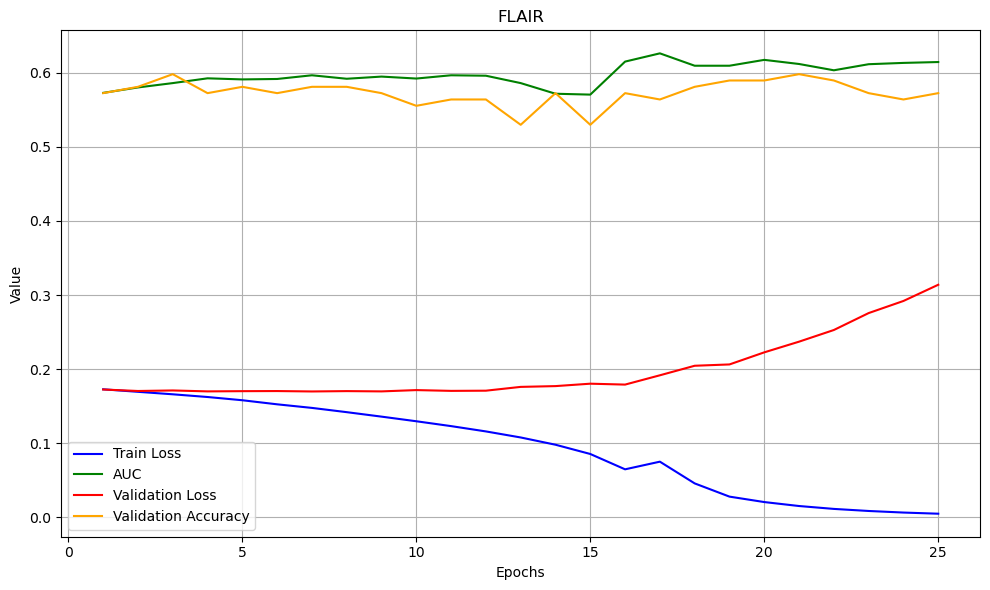

In [29]:
import matplotlib.pyplot as plt

# Example data (replace with your actual lists)
epochs = range(1, len(train_loss_list) + 1)

# Plotting all metrics on the same graph
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss_list, label='Train Loss', color='blue')
plt.plot(epochs, auc_list, label='AUC', color='green')
plt.plot(epochs, val_loss_list, label='Validation Loss', color='red')
plt.plot(epochs, val_acc_list, label='Validation Accuracy', color='orange')

plt.title(mri_type)
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


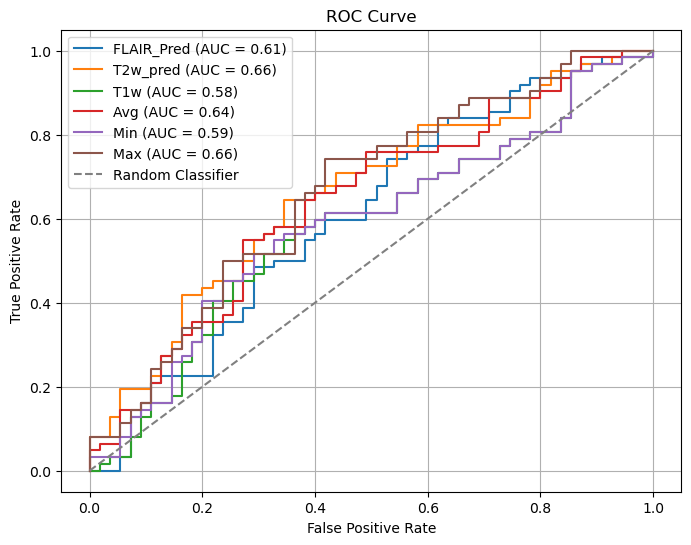

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Read data from CSV file
data = pd.read_csv("auc_dense_all.csv")

# Extract test labels and predictions for each classifier
test_labels = data.iloc[:, 0]
predictions = data.iloc[:, 1:]

# Calculate AUC score for each column and plot ROC curve
plt.figure(figsize=(8, 6))
for classifier_name in predictions.columns:
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[classifier_name])
    auc_score = roc_auc_score(test_labels, predictions[classifier_name])
    plt.plot(fpr, tpr, label=f"{classifier_name} (AUC = {auc_score:.2f})")

# Plot ROC curve for random classifier (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
